# 샤프, 라임 

### 코랩 다운로드

In [ ]:
! pip install git+https://github.com/yura52/rtdl.git

  Cloning https://github.com/yura52/rtdl.git to /tmp/pip-req-build-wpuz8o_7
  Running command git clone --filter=blob:none --quiet https://github.com/yura52/rtdl.git /tmp/pip-req-build-wpuz8o_7
  Resolved https://github.com/yura52/rtdl.git to commit bdc2fe52e0c28d0d15a3cf7d99ef94a452f23253
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 139.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━

### 라이브러리 호출

In [2]:
import shap
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import shap

# 한글 폰트 설정 (Windows 기본 폰트)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지



### shap summary

  0%|          | 0/80 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  pl.tight_layout()
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from font(s) DejaVu Sans.
  pl.tight_layout()
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  pl.tight_layout()
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1153: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  pl.tight_layout()
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:761: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:761: UserWarning: Glyph 48264 (\N{HANGU

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


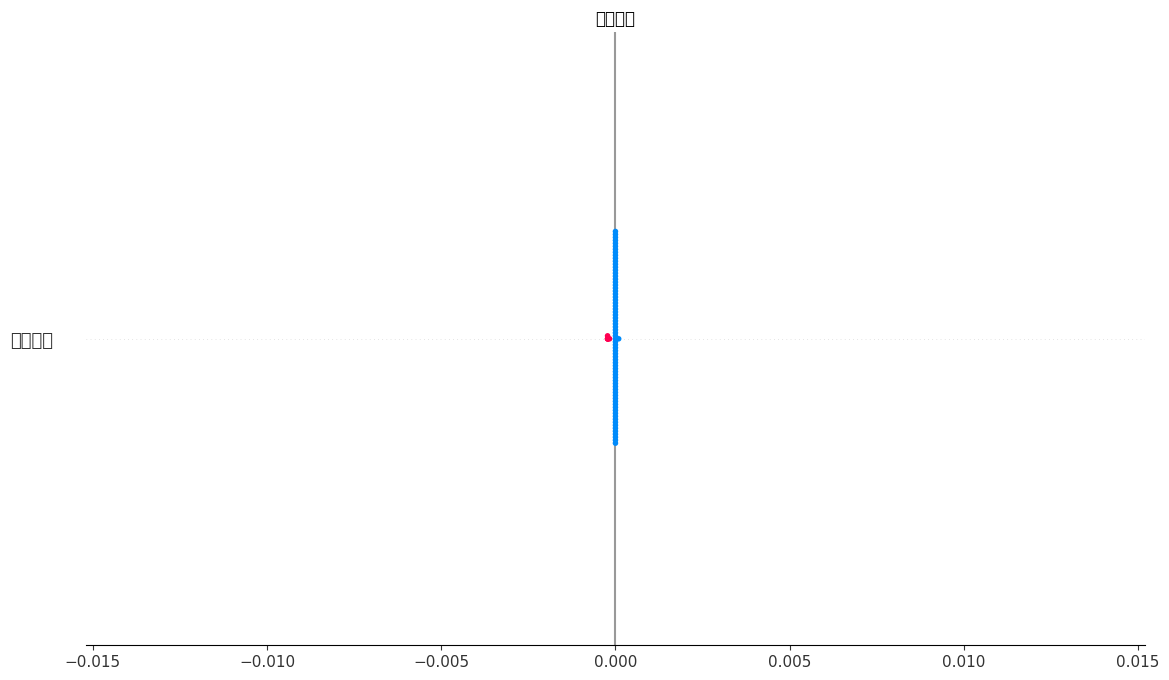

In [ ]:
# 1. 텐서 데이터 불러오기
with open("./split_data/VIF_split_data_fn_transformer.pkl", "rb") as f:
    X_train_tensor, X_valid_tensor, X_test_tensor, y_train_tensor, y_valid_tensor, y_test_tensor = pickle.load(f)

# 2. numpy로 변환
X_train_np = X_train_tensor.numpy()

# 3. 컬럼명 적용
columns = [
    '지번구분', '시도명', '지목', '용도지역1', '주위환경',
    '지세명', '형상명', '도로교통', '용도지구', '농지구분',
    '기타제한', '계획시설_저촉여부'
]
X_train_df = pd.DataFrame(X_train_np, columns=columns)
X_train_df = X_train_df.astype(np.float32)
# 4. 모델 불러오기
from rtdl import FTTransformer
from torch.serialization import safe_globals

with safe_globals([FTTransformer]):
    model = torch.load("./model/VIF_fttransformer_trained.pt", weights_only=False, map_location=torch.device("cpu"))
model.eval()

# 5. 예측 함수 정의 (범주형 입력만 사용하는 구조)
def model_predict(X_numpy):
    X_tensor = torch.tensor(X_numpy, dtype=torch.float32)
    x_cat = X_tensor.long()
    with torch.no_grad():
        output = model(None, x_cat)
    return output.detach().cpu().numpy()

# 6. SHAP KernelExplainer 사용
explainer = shap.KernelExplainer(model_predict, shap.kmeans(X_train_df, 80))

# 7. 일부 샘플로 SHAP 값 계산
X_sample = X_train_df.sample(n=80, random_state=42)
shap_values = explainer.shap_values(X_sample)

# 1. SHAP 값 저장
with open("shap_values.pkl", "wb") as f:
    pickle.dump(shap_values, f)

# 8. Summary plot
# 이 부분 오류 발생, 차원의 크기가 다름
# 밑에 코드에서 차원을 줄이니 해결
shap.summary_plot(shap_values, X_sample)


shap value가 3차원으로 저장되어 오류 발생 -> squeeze 함수 이용해서 불필요한 차원 축소

In [ ]:
# 1. 텐서 데이터 불러오기
with open("./split_data/VIF_split_data_fn_transformer.pkl", "rb") as f:
    X_train_tensor, _, _, _, _, _ = pickle.load(f)

# 2. numpy로 변환
X_train_np = X_train_tensor.numpy()

# 3. 컬럼명 적용
columns = [
    '지번구분', '시도명', '지목', '용도지역1', '주위환경',
    '지세명', '형상명', '도로교통', '용도지구', '농지구분',
    '기타제한', '계획시설_저촉여부'
]
X_train_df = pd.DataFrame(X_train_np, columns=columns)
X_train_df = X_train_df.astype(np.float32)

# 4. 동일한 샘플 추출
X_sample = X_train_df.sample(n=80, random_state=42)

with open("shap_sample.pkl", "wb") as f:
    pickle.dump(X_sample, f)


In [ ]:
"""
# 1. 원래 SHAP 값 불러오기
with open("shap_values.pkl", "rb") as f:
    shap_values = pickle.load(f)

print("변경 전 shape:", shap_values.shape)  # (80, 12, 1)

# 2. 차원 축소
shap_values = np.squeeze(shap_values)
print("변경 후 shape:", shap_values.shape)  # (80, 12)

# 3. 다시 저장
with open("shap_values.pkl", "wb") as f:
    pickle.dump(shap_values, f)

print("저장 완료: shap_values.pkl")
"""

변경 전 shape: (80, 12, 1)
변경 후 shape: (80, 12)
저장 완료: shap_values.pkl


In [8]:
# SHAP 값 불러오기
with open("./shap,lime/shap_values.pkl", "rb") as f:
    shap_values = pickle.load(f)
with open("./shap,lime/shap_sample.pkl", "rb") as f:
    X_sample = pickle.load(f)

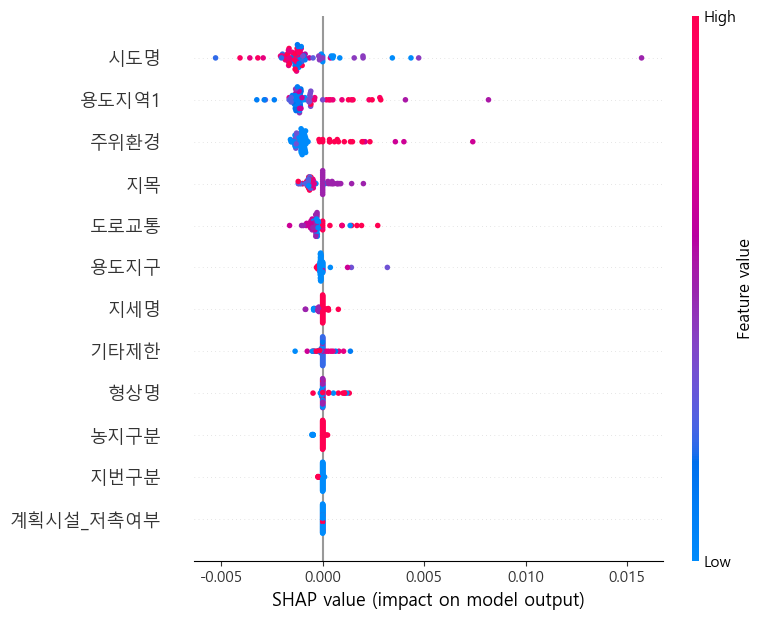

In [9]:
# summary plot 출력
shap.summary_plot(shap_values, X_sample)

모델은 지역(시도명), 토지의 용도(용도지역1), 주변 조건(주위환경)에 따라 공시지가를 가장 강하게 예측하고 있으며, 일부 규제나 제한 조건은 예측에 거의 영향을 주지 않는다.

그러나, ft-transformer 구조상, 명목형 변수를 다 라벨 인코딩하기 때문에, 어떤 지역의 값이 크고 작음은 해석X 즉 색은 해석X

### dependency

In [10]:
with open("label_maps.pkl", "rb") as f:
    label_maps = pickle.load(f)

print("✅ label_maps 불러오기 완료!")

✅ label_maps 불러오기 완료!


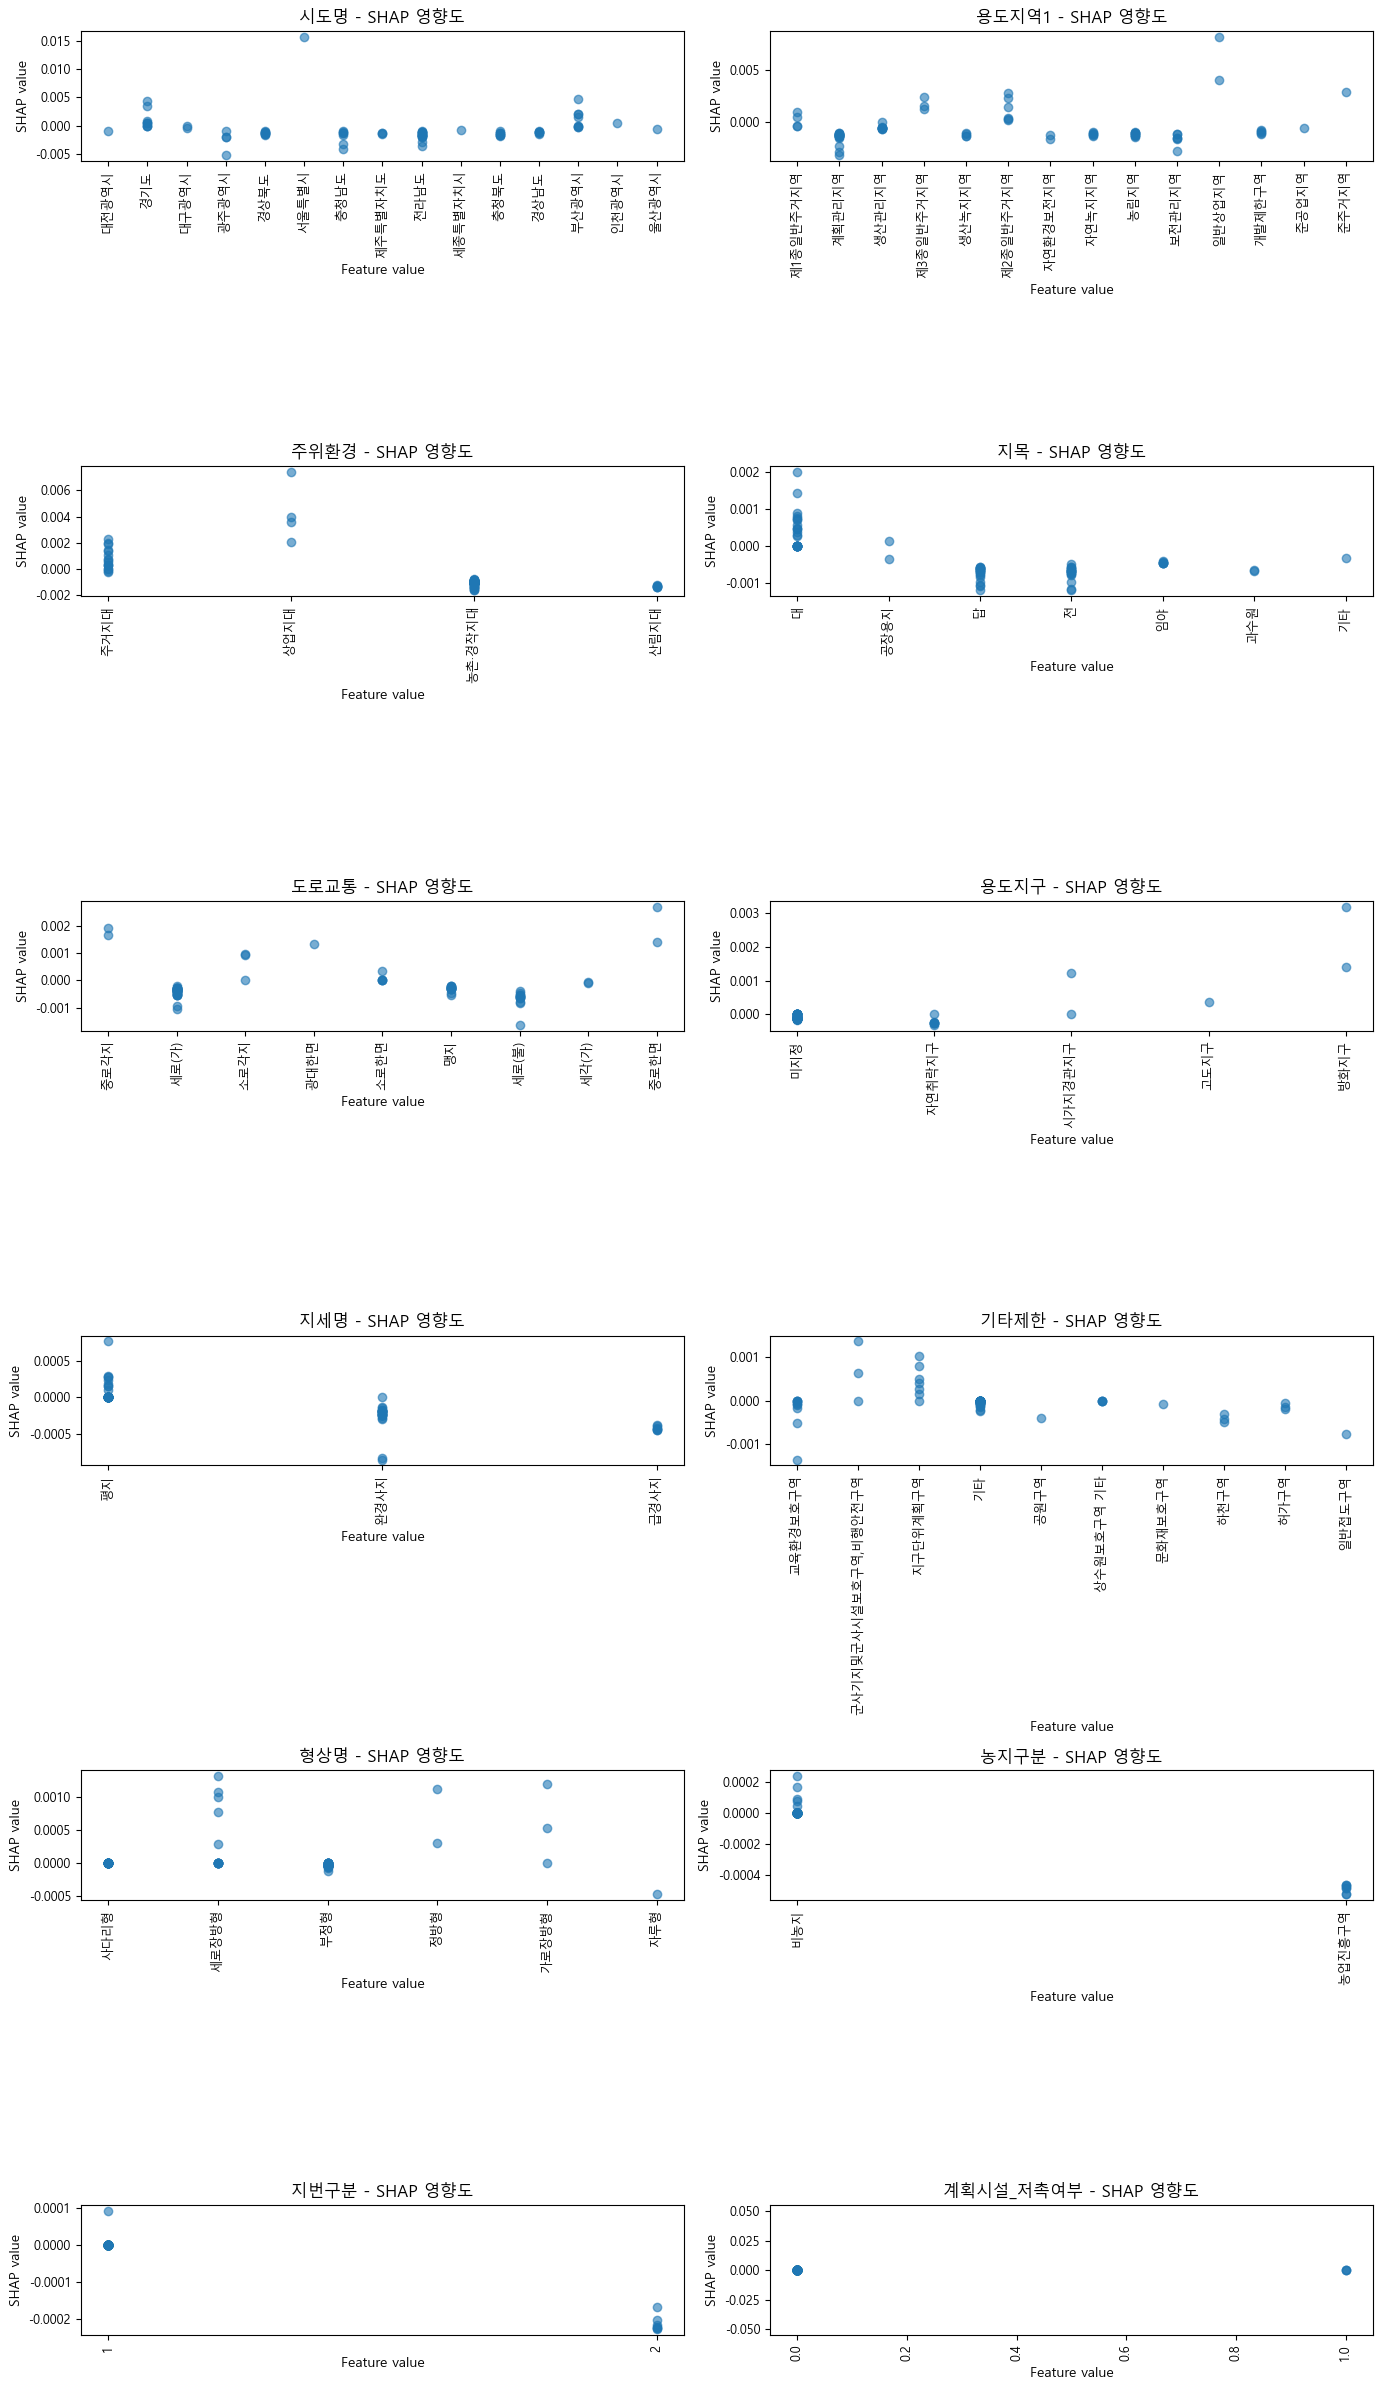

In [11]:
# 3. SHAP 중요도 순서대로 변수 정렬
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(mean_abs_shap, index=X_sample.columns).sort_values(ascending=False)
top_features = shap_importance.index.tolist()  # 전체 변수

# 4. subplot 자동 계산
n_features = len(top_features)
n_cols = 2
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten()

# 5. subplot마다 SHAP dependency plot 그리기
for i, feature in enumerate(top_features):
    ax = axes[i]
    
    x = X_sample[feature].astype(int)
    y = shap_values[:, X_sample.columns.get_loc(feature)]

    if feature in label_maps:
        x_mapped = x.map(label_maps[feature])
    else:
        x_mapped = x

    ax.scatter(x_mapped, y, alpha=0.6)
    ax.set_title(f"{feature} - SHAP 영향도", fontsize=12)
    ax.set_xlabel("Feature value", fontsize=10)
    ax.set_ylabel("SHAP value", fontsize=10)
    
    # ✅ 겹침 방지
    ax.tick_params(axis='x', labelrotation=90, labelsize=9)
    ax.tick_params(axis='y', labelsize=9)

# 6. 남는 subplot 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


| 변수명            | 주요 특징값 또는 경향      | SHAP 영향 방향      | 해석 요약                             |
| -------------- | ----------------- | --------------- | --------------------------------- |
| **시도명**        | 세종, 서울 등 일부 시도    | ↑               | 지역에 따라 공시지가 예측값이 크게 다름. 지역이 핵심 변수 |
| **용도지역1**      | 제1종전용주거지역, 상업지역 등 | ↑               | 상업/전용주거지역일수록 공시지가 상승              |
| **주위환경**       | 상업지역, 혼합지역        | ↑               | 상업 중심 지역일수록 높은 공시지가 예측            |
| **지목**         | 대, 공장용지 등         | ↑               | 개발 가능한 토지일수록 예측값 높음. 임야, 전은 낮음    |
| **도로교통**       | 중로접지, 소로접지 등      | ↑               | 더 넓은 도로에 접한 토지가 예측에 긍정적 영향        |
| **용도지구**       | 제2종일반주거지, 자연녹지    | ↑               | 개발 가능성 있는 용도지구일수록 가치 반영           |
| **지세명**        | 평지, 완경사지 등        | ↑               | 평지일수록 토지 가치가 높게 반영됨               |
| **기타제한**       | 문화재구역, 군사시설보호구역 등 | ↔/↓             | 대부분 예측에 영향 적음, 일부 제한은 소폭 영향       |
| **형상명**        | 직사각형, 정방형, 사다리형   | ↑               | 규칙적인 형태의 토지가 높은 가치로 예측됨           |
| **농지구분**       | 배농지 vs 농업진흥지역     | ↑ (배농지), ↓ (진흥) | 개발 가치가 높은 비농지일수록 고평가됨             |
| **지번구분**       | 1, 2 등 라벨값        | ↓ (특정값)         | 일부 구분값은 낮은 SHAP 값 → 부정적 영향        |
| **계획시설\_저촉여부** | 1.0일 때            | ↑               | 계획시설에 포함될 경우 예외적으로 예측값 증가         |


### force plot

In [25]:
#  명목형 변수 이름 매핑 함수

def apply_label_maps(df, label_maps):
    df_copy = df.copy()
    for col in df_copy.columns:
        if col in label_maps:
            df_copy[col] = df_copy[col].map(label_maps[col])
    return df_copy

# 변수 이름 매핑된 df 생성
X_sample_mapped = apply_label_maps(X_sample, label_maps)


🔹 샘플 0번


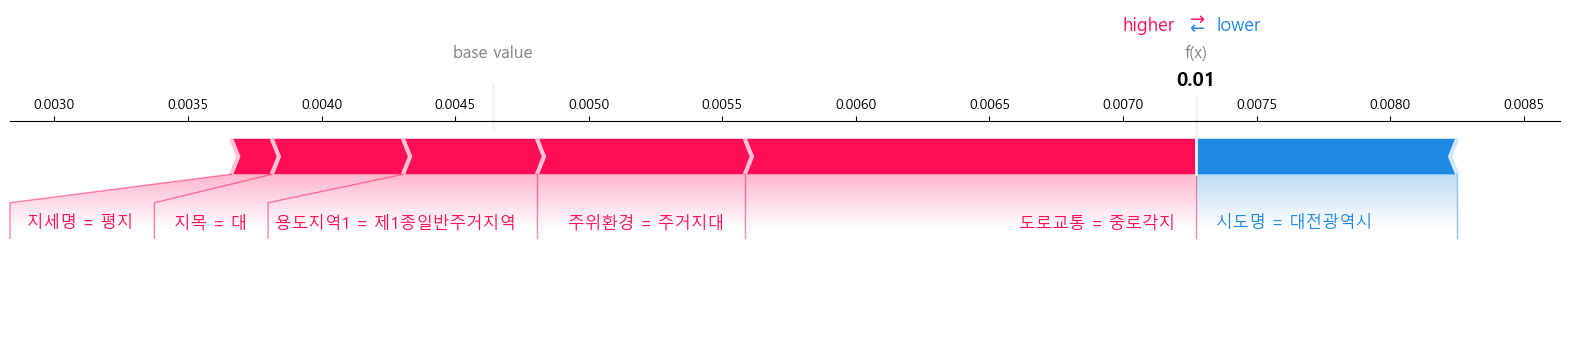

🔹 샘플 1번


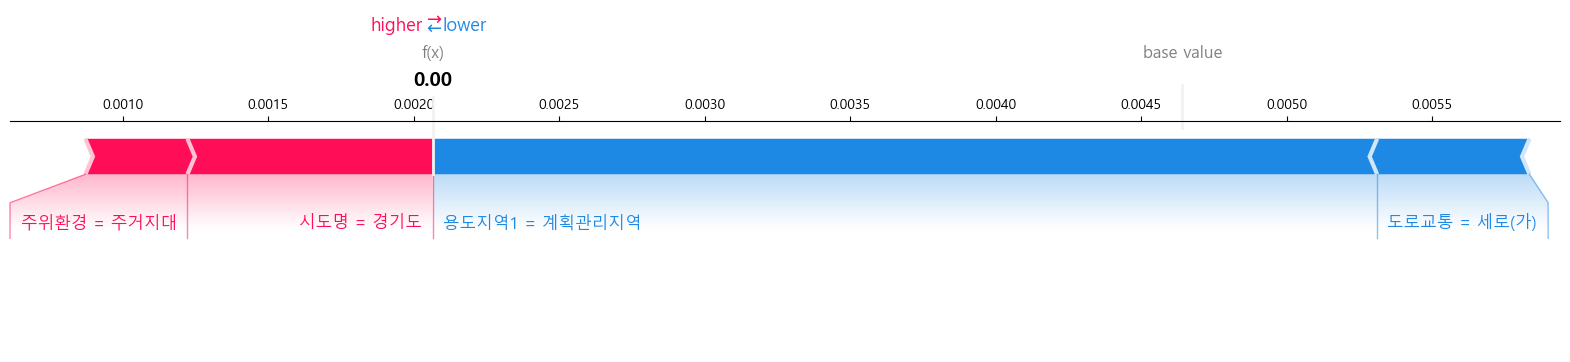

🔹 샘플 2번


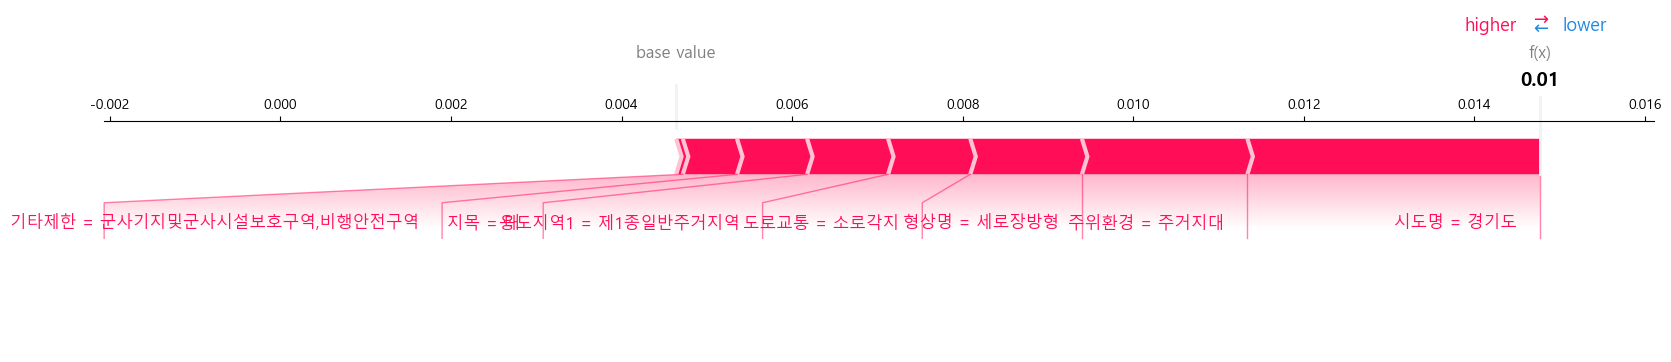

🔹 샘플 3번


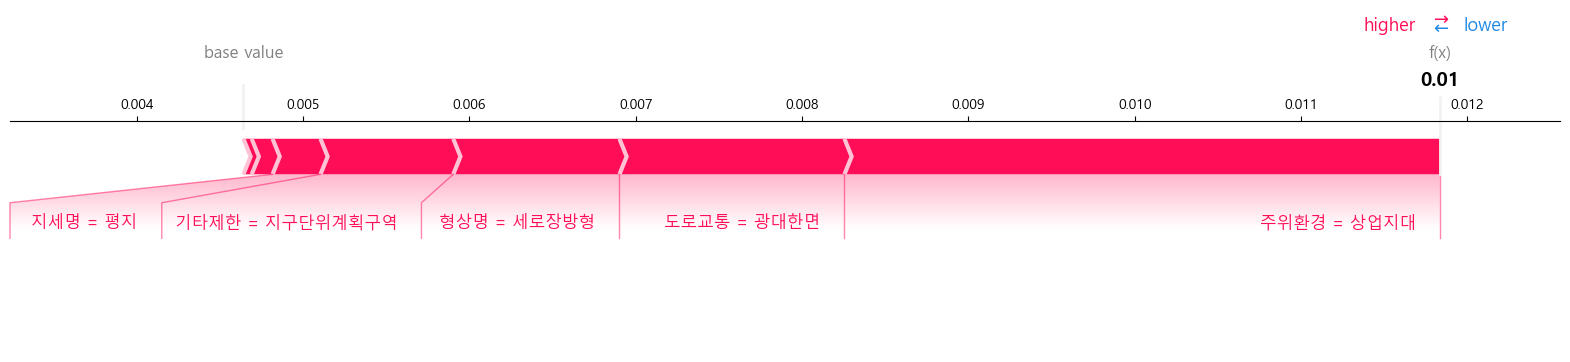

🔹 샘플 4번


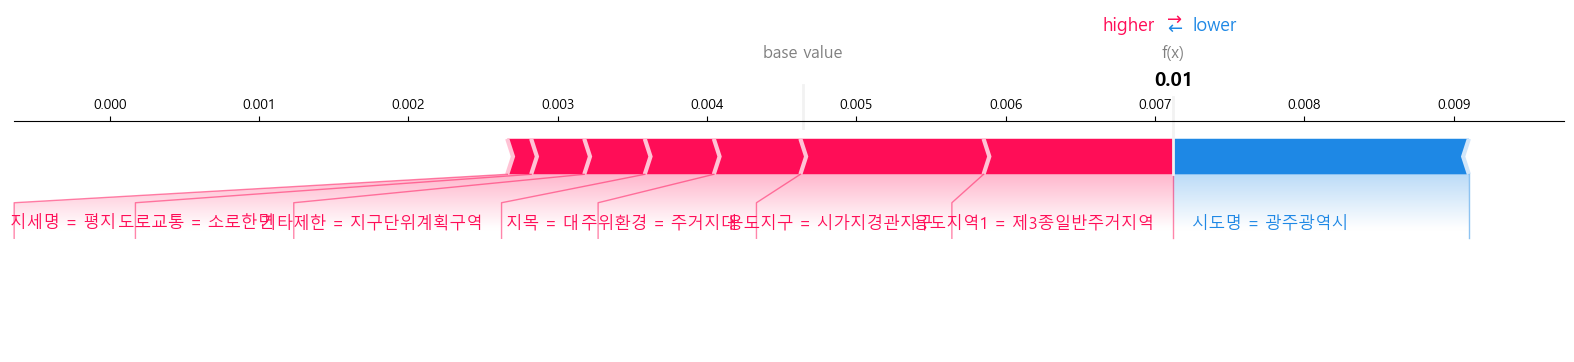

🔹 샘플 5번


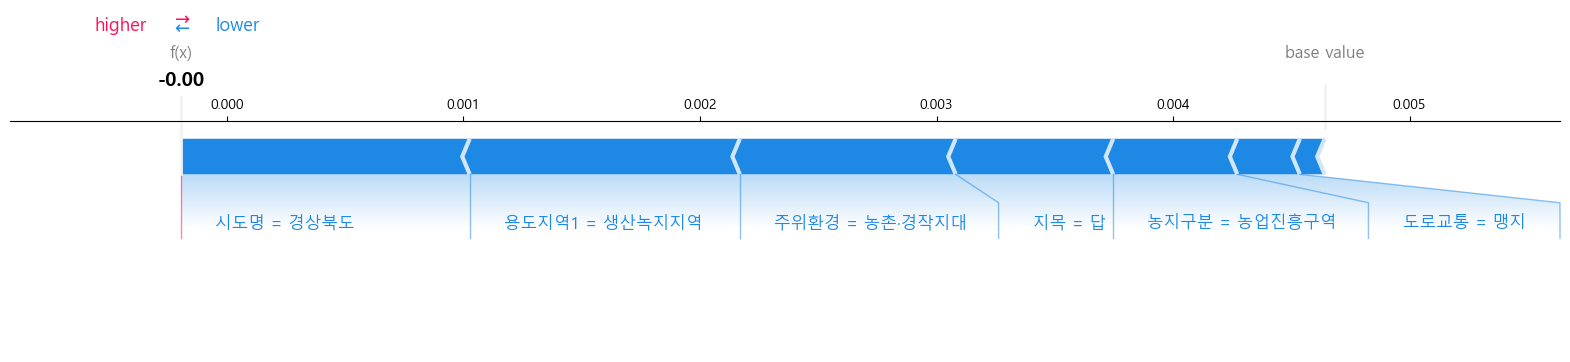

🔹 샘플 6번


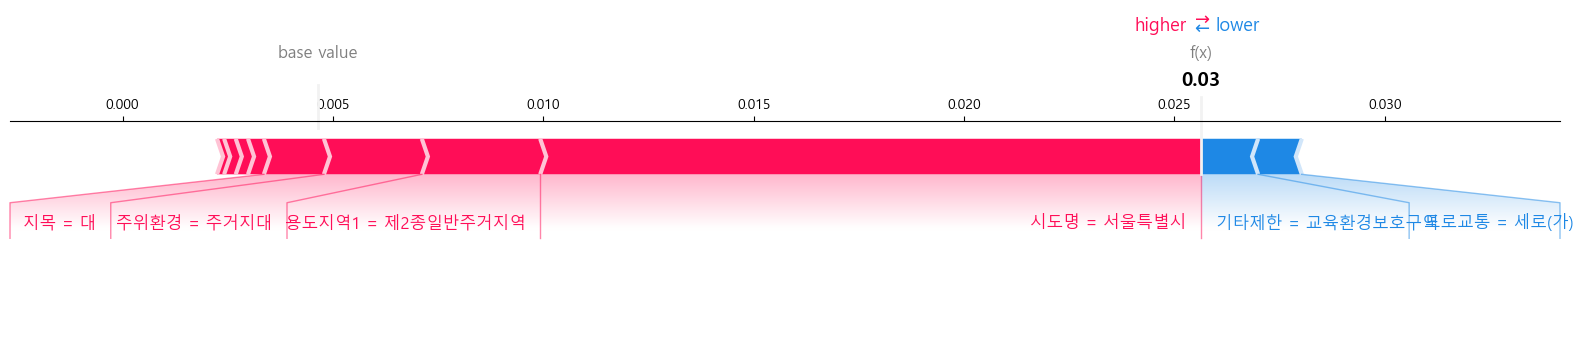

🔹 샘플 7번


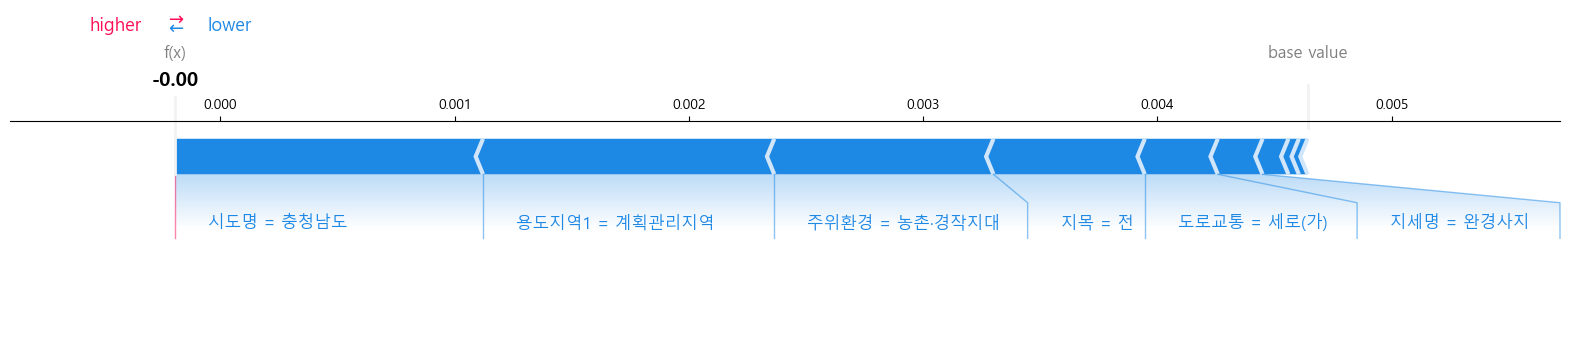

🔹 샘플 8번


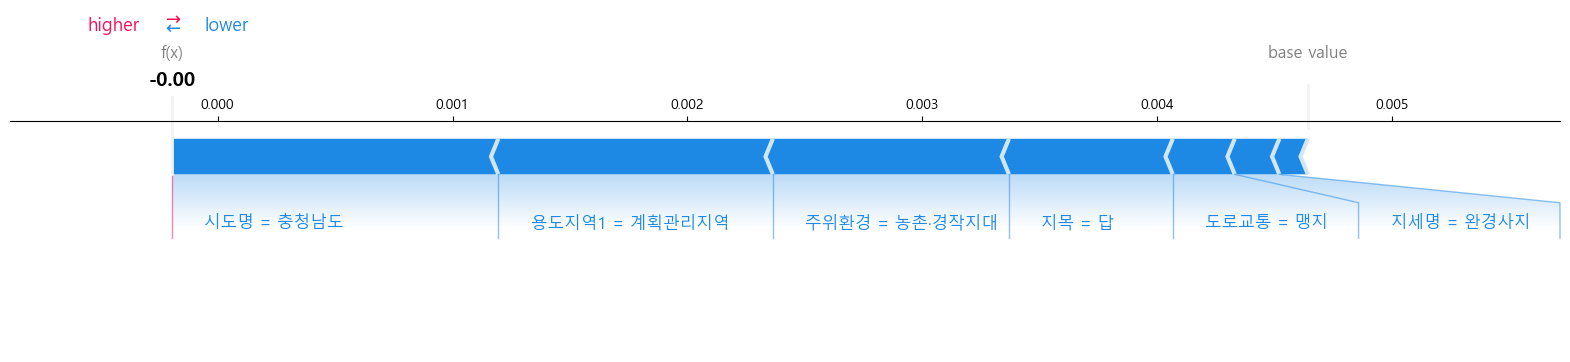

🔹 샘플 9번


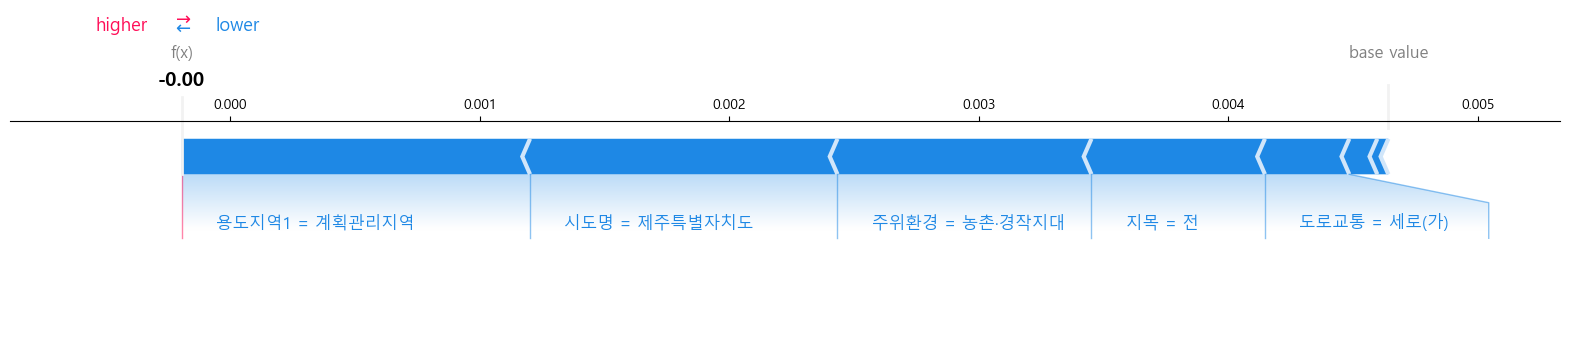

In [26]:
expected_value = explainer.expected_value

# force plot 여러 개 연속 출력
for i in range(10):
    print(f"🔹 샘플 {i}번")
    shap.force_plot(
        expected_value,
        shap_values[i],
        X_sample_mapped.iloc[i],
        matplotlib=True
    )


### LIME

In [ ]:
from rtdl import FTTransformer
from torch.serialization import safe_globals

with safe_globals([FTTransformer]):
    model = torch.load("./model/VIF_fttransformer_trained.pt", weights_only=False, map_location=torch.device("cpu"))
model.eval() # 평가 모드

FTTransformer(
  (feature_tokenizer): FeatureTokenizer(
    (cat_tokenizer): CategoricalFeatureTokenizer(
      (embeddings): Embedding(90, 64)
    )
  )
  (cls_token): CLSToken()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): ModuleDict(
        (attention): MultiheadAttention(
          (W_q): Linear(in_features=64, out_features=64, bias=True)
          (W_k): Linear(in_features=64, out_features=64, bias=True)
          (W_v): Linear(in_features=64, out_features=64, bias=True)
          (W_out): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.1971837206675287, inplace=False)
        )
        (ffn): FFN(
          (linear_first): Linear(in_features=64, out_features=1024, bias=True)
          (activation): ReGLU()
          (dropout): Dropout(p=0.1971837206675287, inplace=False)
          (linear_second): Linear(in_features=512, out_features=64, bias=True)
        )
        (attention_residual_dropout): Dropout(p=0.19718372066752

In [4]:
# label_maps에 학습에 사용되지 않은 변수 존재 -> 삭제

# 제거 대상
drop_vars = ['이용상황', '임야구분']

# 새로운 label_maps 생성
label_maps = {k: v for k, v in label_maps.items() if k not in drop_vars}

# 확인
print("최종 변수 목록:", list(label_maps.keys()))


최종 변수 목록: ['지번구분', '시도명', '지목', '용도지역1', '주위환경', '지세명', '형상명', '도로교통', '용도지구', '농지구분', '기타제한', '계획시설 저촉여부']


In [ ]:
import lime
import lime.lime_tabular
from tqdm import tqdm

# 1. 500개 샘플 불러오기
X_sample_lime = torch.load("./shap,lime/X_sample_lime.pt", map_location="cpu")
X_sample_lime_df = pd.DataFrame(X_sample_lime.numpy())

# 2. 컬럼명 적용 (label_maps 순서 기준)
columns = list(label_maps.keys())
X_sample_lime_df.columns = columns

# 3. 예측 함수 정의 
def model_predict_fn(X_numpy):
    X_tensor = torch.tensor(X_numpy, dtype=torch.float32)
    with torch.no_grad():
        output = model(None, X_tensor.long())  # 기존에 불러온 model 그대로 사용
    return output.detach().cpu().numpy()

# 4. LIME explainer 정의
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_sample_lime_df.values,
    feature_names=X_sample_lime_df.columns.tolist(),
    class_names=["공시지가"],
    mode="regression",
    categorical_features=[X_sample_lime_df.columns.get_loc(col) for col in label_maps],
    categorical_names={X_sample_lime_df.columns.get_loc(col): list(label_maps[col].values()) for col in label_maps}
)
# 6. 500개 샘플에 대해 반복적으로 LIME 해석
lime_results = []

for i in tqdm(range(len(X_sample_lime_df))):
    exp = explainer.explain_instance(
        data_row=X_sample_lime_df.iloc[i].values,
        predict_fn=model_predict_fn,
        num_features=10
    )
    for feature, weight in exp.as_list():
        lime_results.append({
            "샘플번호": i,
            "변수": feature,
            "기여도": weight
        })
# 6. 결과 저장
df_lime = pd.DataFrame(lime_results)
print(df_lime)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [22:23<00:00,  2.69s/it]

      샘플번호            변수       기여도
0        0     주위환경=산림지대 -0.001477
1        0      시도명=충청남도 -0.001223
2        0        지번구분=2 -0.000712
3        0         지목=임야 -0.000527
4        0  용도지역1=자연녹지지역 -0.000496
...    ...           ...       ...
4995   499      농지구분=비농지  0.000714
4996   499    도로교통=세로(가) -0.000370
4997   499        지세명=평지  0.000352
4998   499   계획시설 저촉여부=N  0.000278
4999   499        지번구분=1  0.000272

[5000 rows x 3 columns]


In [ ]:
with open("./shap,lime/lime_values.pkl", "wb") as f:
    pickle.dump(df_lime, f)

print("저장 완료: lime_values.pkl")

저장 완료: lime_values.pkl


C:\Users\jeongbin\AppData\Local\Temp\ipykernel_32780\1644444803.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="기여도", y="변수", data=sample, palette="coolwarm")


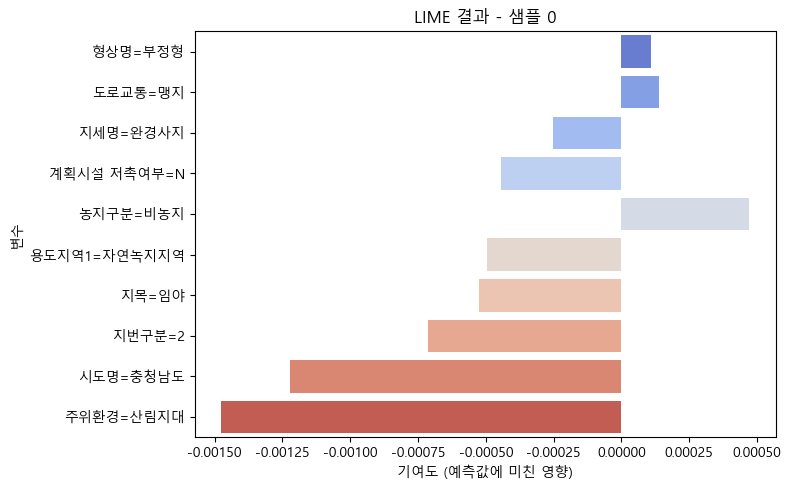

C:\Users\jeongbin\AppData\Local\Temp\ipykernel_32780\1644444803.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="기여도", y="변수", data=sample, palette="coolwarm")


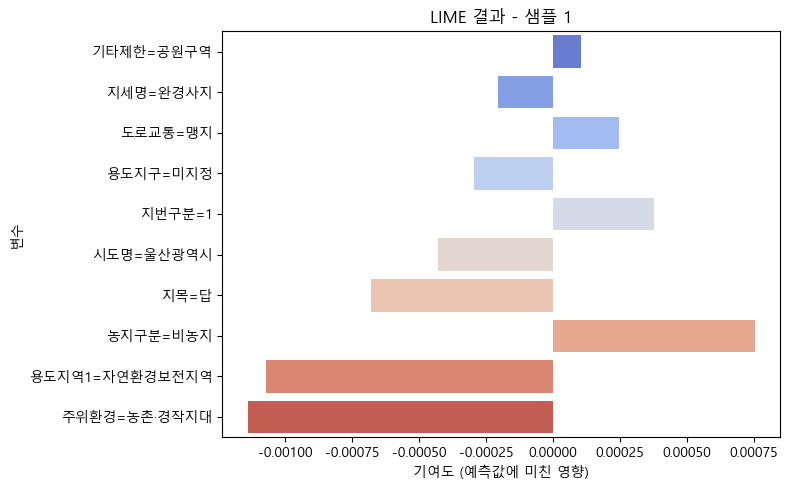

C:\Users\jeongbin\AppData\Local\Temp\ipykernel_32780\1644444803.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="기여도", y="변수", data=sample, palette="coolwarm")


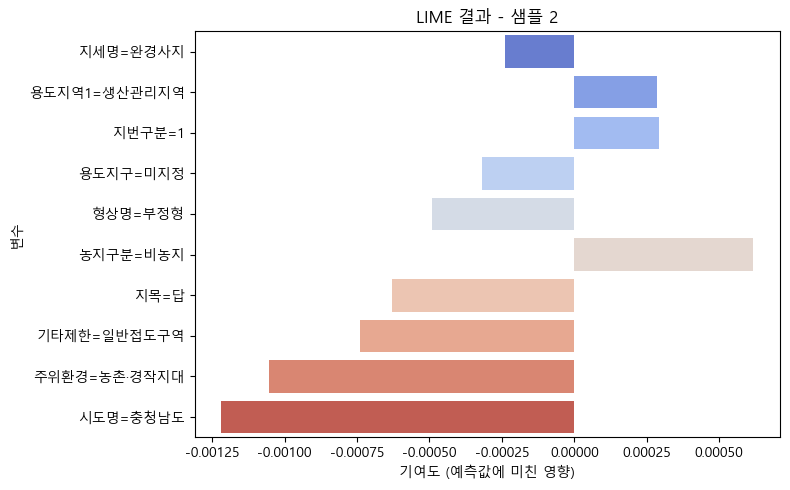

C:\Users\jeongbin\AppData\Local\Temp\ipykernel_32780\1644444803.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="기여도", y="변수", data=sample, palette="coolwarm")


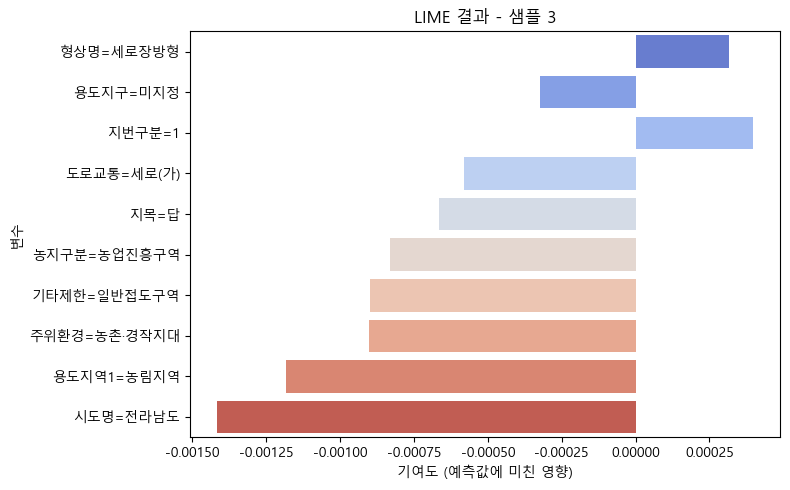

C:\Users\jeongbin\AppData\Local\Temp\ipykernel_32780\1644444803.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="기여도", y="변수", data=sample, palette="coolwarm")


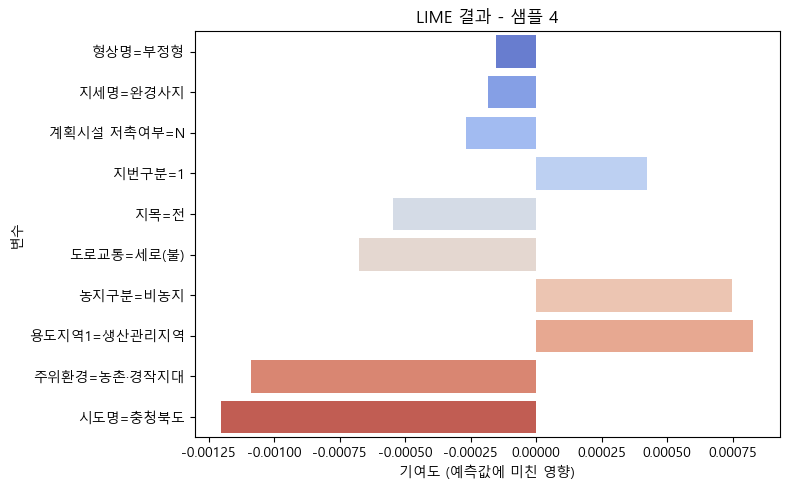

C:\Users\jeongbin\AppData\Local\Temp\ipykernel_32780\1644444803.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="기여도", y="변수", data=sample, palette="coolwarm")


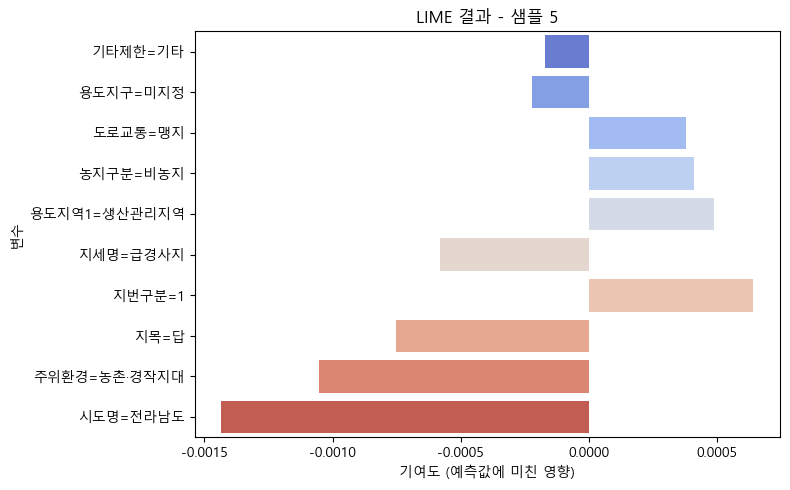

C:\Users\jeongbin\AppData\Local\Temp\ipykernel_32780\1644444803.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="기여도", y="변수", data=sample, palette="coolwarm")


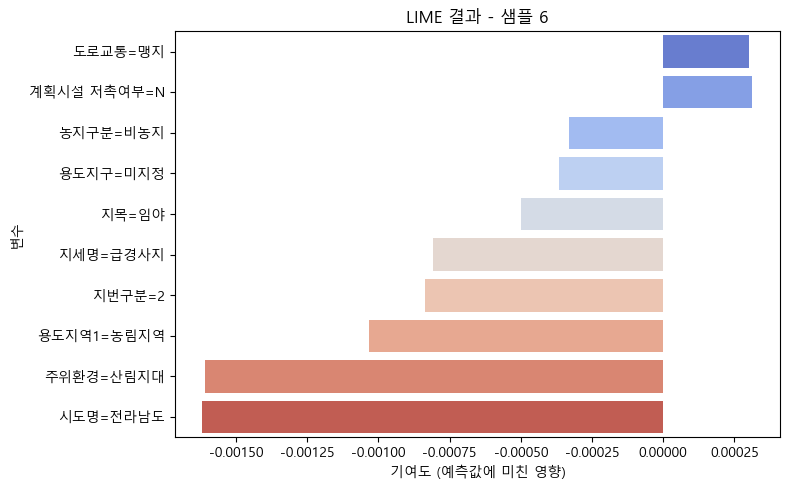

C:\Users\jeongbin\AppData\Local\Temp\ipykernel_32780\1644444803.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="기여도", y="변수", data=sample, palette="coolwarm")


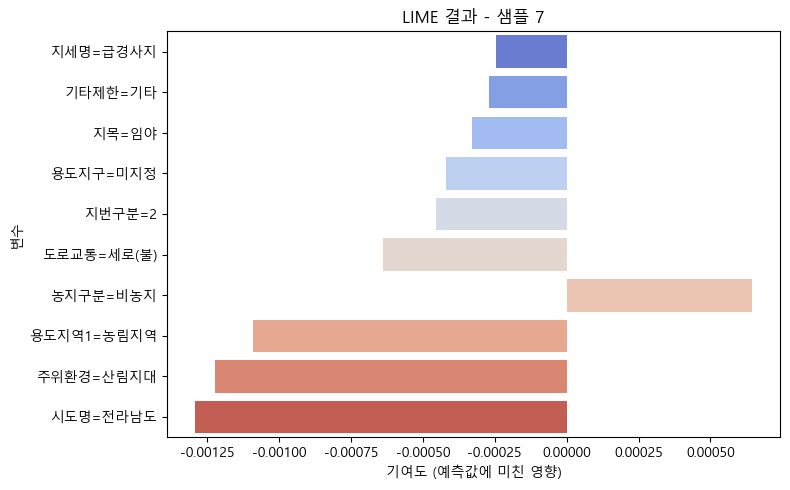

C:\Users\jeongbin\AppData\Local\Temp\ipykernel_32780\1644444803.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="기여도", y="변수", data=sample, palette="coolwarm")


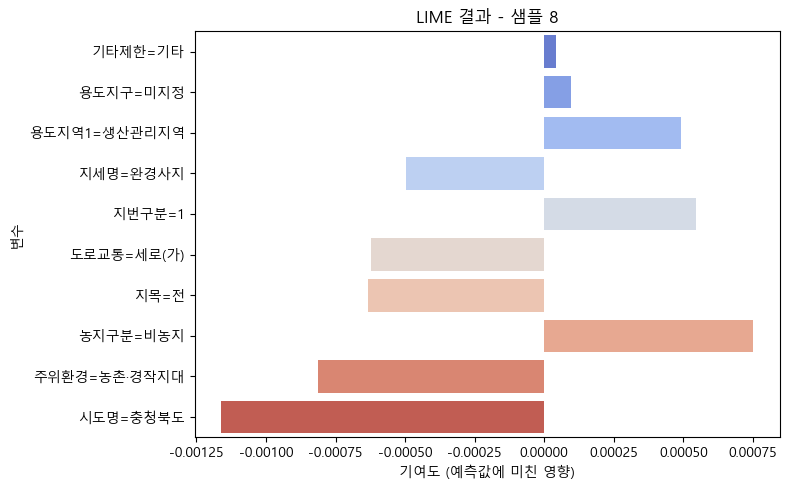

C:\Users\jeongbin\AppData\Local\Temp\ipykernel_32780\1644444803.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="기여도", y="변수", data=sample, palette="coolwarm")


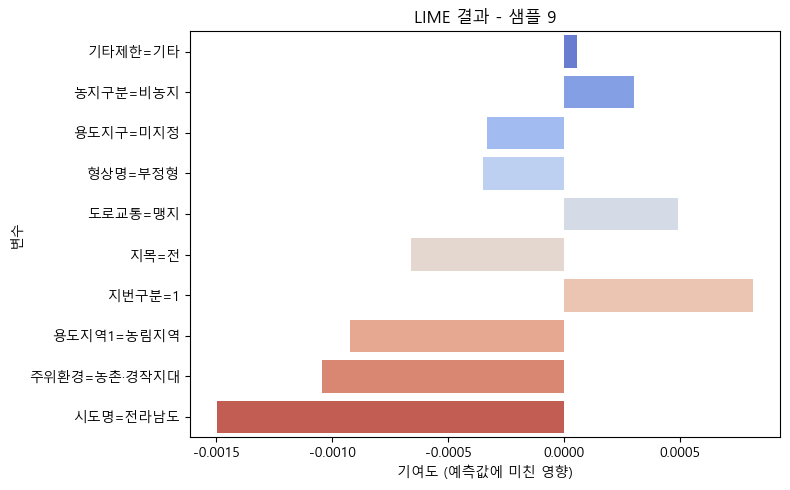

In [9]:
import seaborn as sns

for i in range(10):  # 샘플번호 0~9까지 반복
    sample = df_lime[df_lime["샘플번호"] == i].copy()
    sample = sample.sort_values(by="기여도", key=abs, ascending=True)

    plt.figure(figsize=(8, 5))
    sns.barplot(x="기여도", y="변수", data=sample, palette="coolwarm")
    plt.title(f"LIME 결과 - 샘플 {i}")
    plt.xlabel("기여도 (예측값에 미친 영향)")
    plt.ylabel("변수")
    plt.tight_layout()
    plt.show()


In [36]:
# 변수별 전체 기여도 합산
total_contributions = df_lime.groupby("변수")["기여도"].sum().sort_values(ascending=False)

# 또는 변수별 평균 기여도 (샘플당 영향력 크기)
mean_contributions = df_lime.groupby("변수")["기여도"].mean().sort_values(ascending=False)
print(mean_contributions.head(10)) 

변수
시도명=서울특별시          0.008547
도로교통=광대세각          0.002558
용도지역1=일반상업지역       0.002439
주위환경=상업지대          0.002307
주위환경=기타            0.002289
도로교통=광대소각          0.002124
용도지역1=제3종일반주거지역    0.001697
용도지역1=준주거지역        0.001668
용도지역1=제2종일반주거지역    0.001255
도로교통=중로각지          0.001158
Name: 기여도, dtype: float64


### shap와 같은 데이터로 lime 구해보기

C:\Users\jeongbin\AppData\Local\Temp\ipykernel_32780\3045243394.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="기여도", y="변수", data=lime_df, palette="coolwarm")


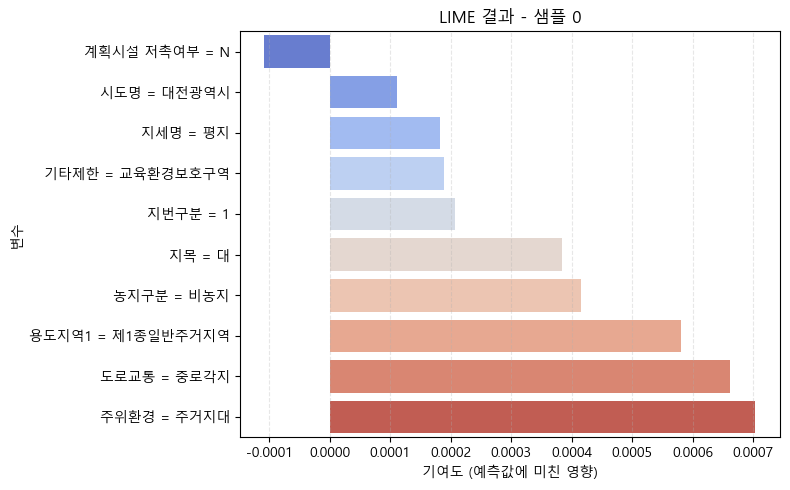

C:\Users\jeongbin\AppData\Local\Temp\ipykernel_32780\3045243394.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="기여도", y="변수", data=lime_df, palette="coolwarm")


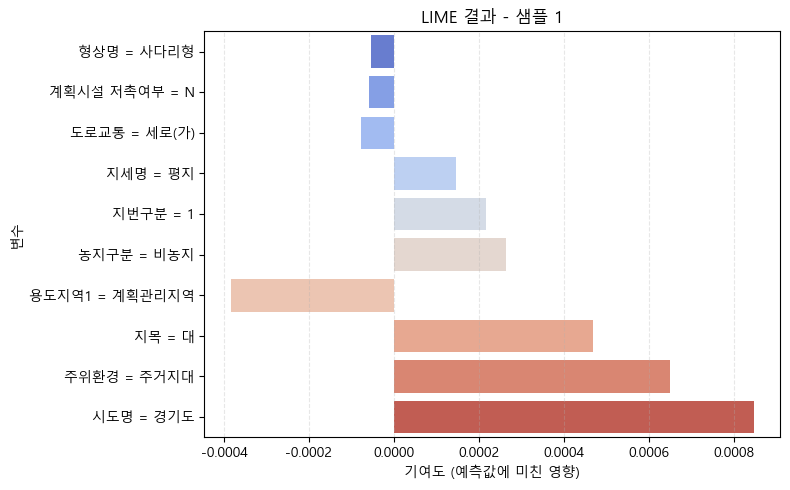

C:\Users\jeongbin\AppData\Local\Temp\ipykernel_32780\3045243394.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="기여도", y="변수", data=lime_df, palette="coolwarm")


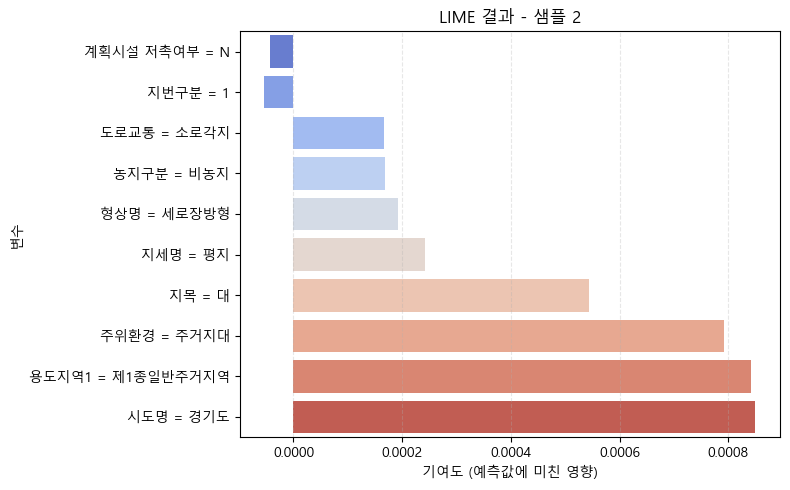

C:\Users\jeongbin\AppData\Local\Temp\ipykernel_32780\3045243394.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="기여도", y="변수", data=lime_df, palette="coolwarm")


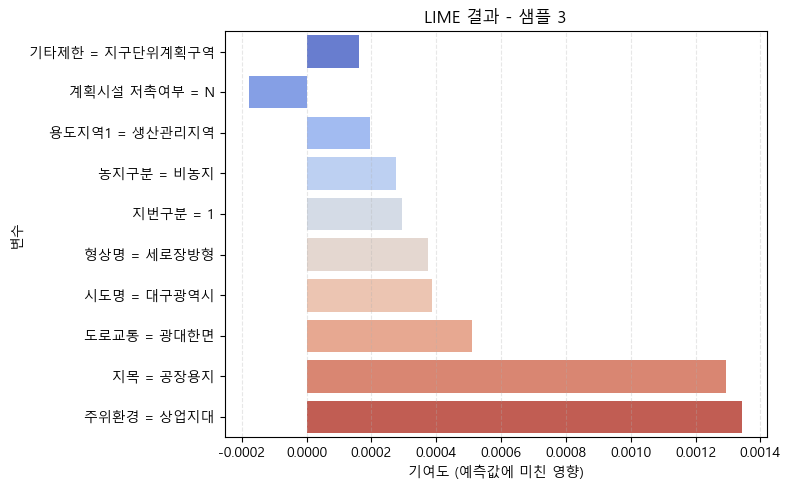

C:\Users\jeongbin\AppData\Local\Temp\ipykernel_32780\3045243394.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="기여도", y="변수", data=lime_df, palette="coolwarm")


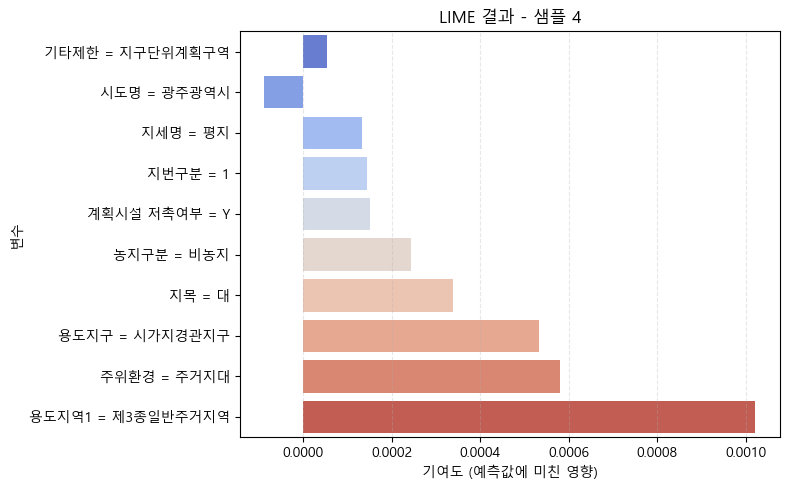

C:\Users\jeongbin\AppData\Local\Temp\ipykernel_32780\3045243394.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="기여도", y="변수", data=lime_df, palette="coolwarm")


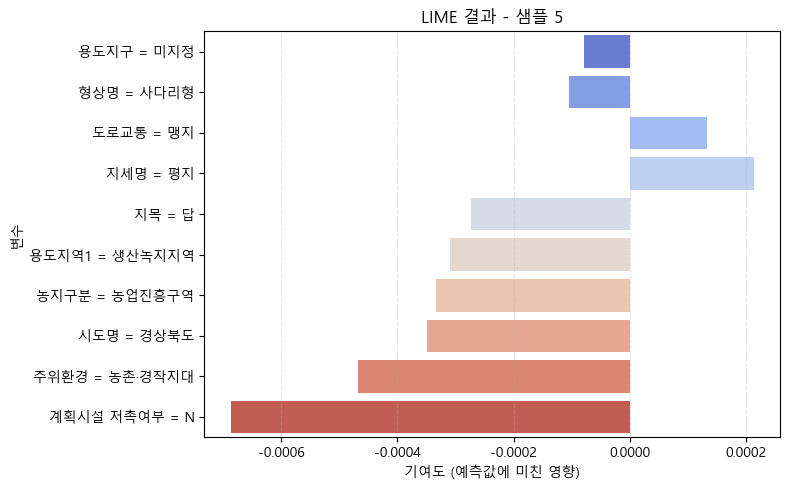

C:\Users\jeongbin\AppData\Local\Temp\ipykernel_32780\3045243394.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="기여도", y="변수", data=lime_df, palette="coolwarm")


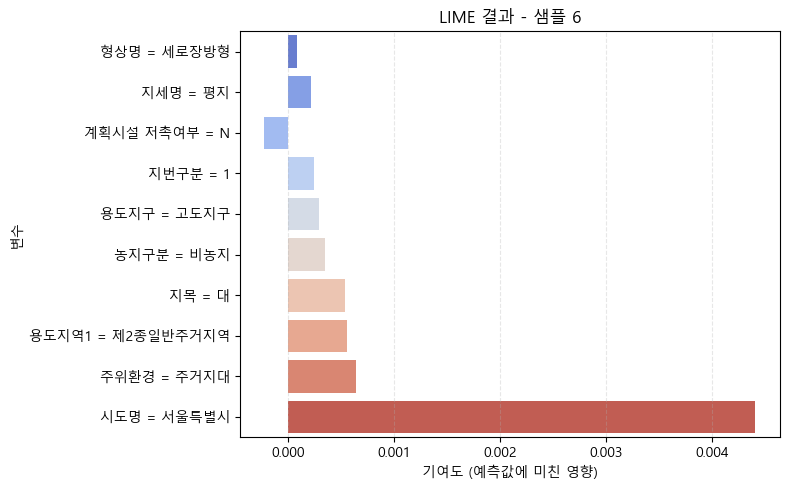

C:\Users\jeongbin\AppData\Local\Temp\ipykernel_32780\3045243394.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="기여도", y="변수", data=lime_df, palette="coolwarm")


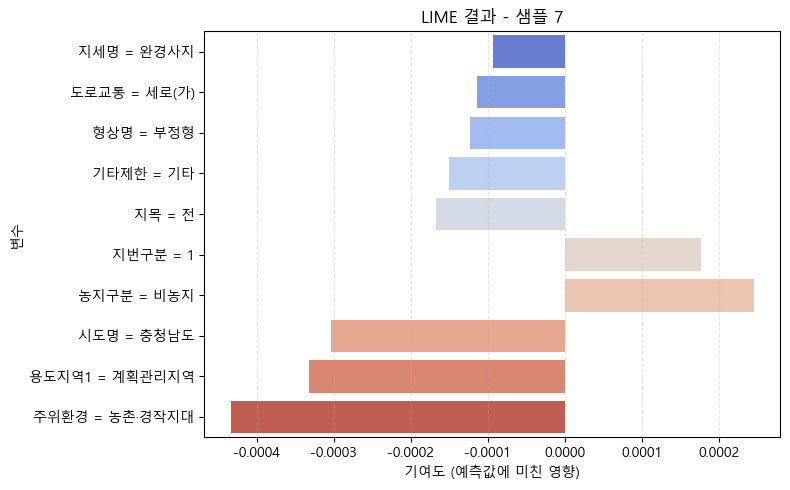

C:\Users\jeongbin\AppData\Local\Temp\ipykernel_32780\3045243394.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="기여도", y="변수", data=lime_df, palette="coolwarm")


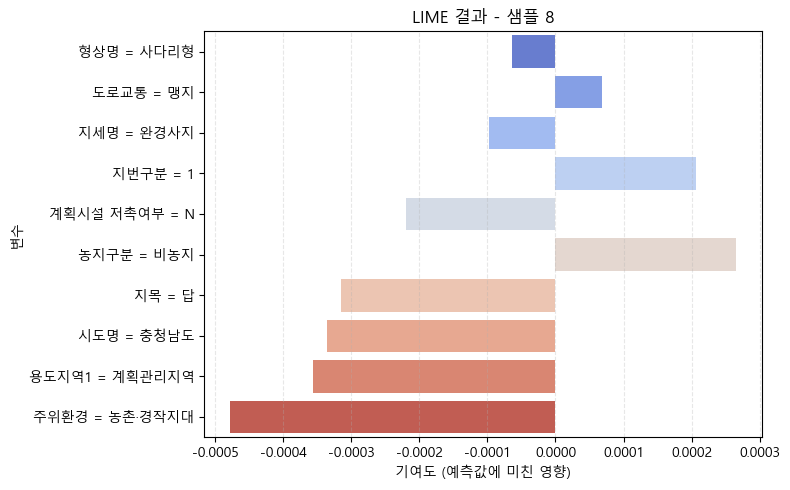

C:\Users\jeongbin\AppData\Local\Temp\ipykernel_32780\3045243394.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="기여도", y="변수", data=lime_df, palette="coolwarm")


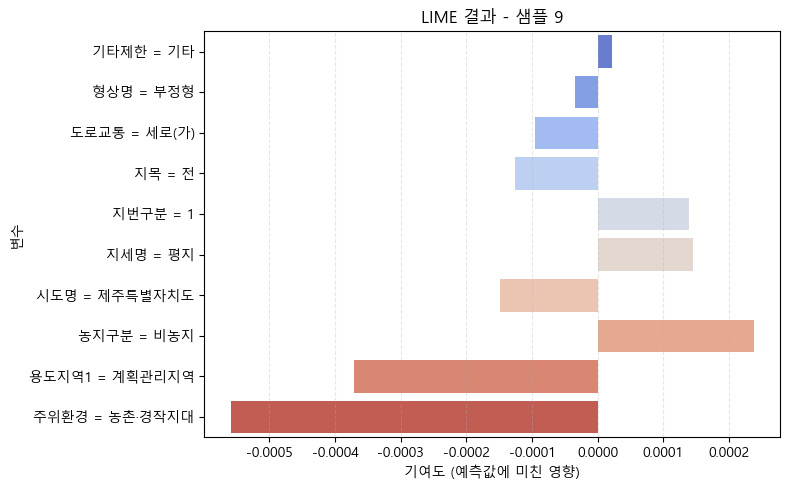

In [ ]:
import pandas as pd
import torch
import numpy as np
from rtdl import FTTransformer
from torch.serialization import safe_globals
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 모델 불러오기
with safe_globals([FTTransformer]):
    model = torch.load("./model/VIF_fttransformer_trained.pt", weights_only=False, map_location=torch.device("cpu"))
model.eval()

# 2. 예측 함수 정의
def model_predict(X_numpy):
    X_tensor = torch.tensor(X_numpy, dtype=torch.float32)
    x_cat = X_tensor.long()
    with torch.no_grad():
        output = model(None, x_cat)
    return output.detach().cpu().numpy()

# 3. 샘플 CSV 불러오기
X_sample = pd.read_csv("./shap,lime/shap_lime_sample.csv")

# ✅ 3.5 컬럼명 재지정 (label_maps를 기반으로)
columns = list(label_maps.keys())
X_sample.columns = columns

# 4. LIME Explainer 정의 (라벨벨 인코딩 매핑 포함)
explainer = LimeTabularExplainer(
    training_data=X_sample.values,
    feature_names=X_sample.columns.tolist(),
    mode="regression",
    categorical_features=[X_sample.columns.get_loc(col) for col in label_maps],
    categorical_names={X_sample.columns.get_loc(col): list(label_maps[col].values()) for col in label_maps}
)

# 5. LIME 시각화 (샘플 0~9)
for i in range(10):
    exp = explainer.explain_instance(
        data_row=X_sample.iloc[i].values,
        predict_fn=model_predict,
        num_features=10
    )

    lime_df = pd.DataFrame(exp.as_list(), columns=["변수", "기여도"])
    lime_df["변수"] = lime_df["변수"].str.replace("=", " = ")
    lime_df = lime_df.sort_values(by="기여도", key=abs, ascending=True)

    plt.figure(figsize=(8, 5))
    sns.barplot(x="기여도", y="변수", data=lime_df, palette="coolwarm")
    plt.title(f"LIME 결과 - 샘플 {i}")
    plt.xlabel("기여도 (예측값에 미친 영향)")
    plt.ylabel("변수")
    plt.grid(axis="x", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()


LIME을 통해, 500개의 샘플에 가장 큰 기여를 한 10개의 값 구함.
그리고, 전체를 합쳐 전체 샘플에 대해 가장 큰 기여를 끼친 값을 구함.

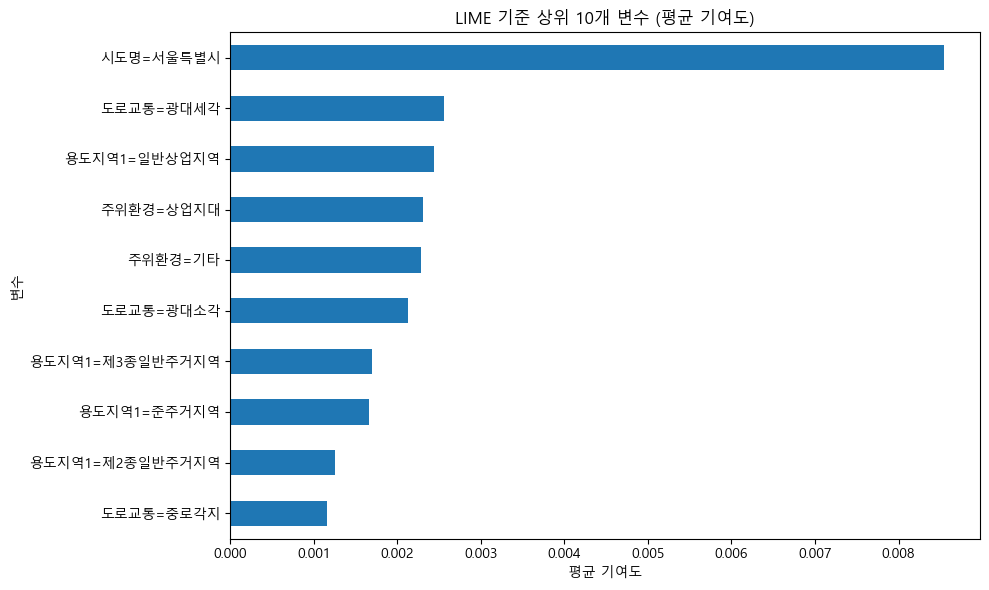

In [37]:
# 상위 10개 변수 추출
top10 = mean_contributions.head(10)

# 시각화
plt.figure(figsize=(10, 6))
top10.plot(kind="barh")
plt.gca().invert_yaxis()  # 기여도 큰 게 위로 오도록
plt.xlabel("평균 기여도")
plt.title("LIME 기준 상위 10개 변수 (평균 기여도)")
plt.tight_layout()
plt.show()
